In [1]:
import pandas as pd
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import sklearn
from sklearn import preprocessing 

from datetime import timedelta
from plotnine import *


import numpy as np
import sklearn
from sklearn import linear_model
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib import style
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

from pickle import dump
from pickle import load

In [2]:
# import COVID data
Covid_cases = pd.read_csv('Raw Case Numbers-Daily New Cases.csv')
Covid_deaths = pd.read_csv('Raw Case Numbers-Daily New Deaths.csv')

In [3]:
Covid_cases = Covid_cases.drop(0)
Covid_deaths = Covid_deaths.drop(0)
# Convert column names to list and exclude the first one
covid_deaths = Covid_deaths.columns.tolist()[1:]
covid_cases = Covid_cases.columns.tolist()[1:]
# reshape table
deaths = pd.melt(Covid_deaths,id_vars = ['Unnamed: 0'],value_vars =covid_deaths)
cases = pd.melt(Covid_cases,id_vars = ['Unnamed: 0'],value_vars =covid_cases)
# Create merge id so that there's not mistakes in merging
deaths['merge_id'] = deaths['Unnamed: 0'] + deaths['variable']
cases['merge_id'] = cases['Unnamed: 0'] + cases['variable']
# Merge talbe using merge_id
covid = cases.merge(deaths, on='merge_id', how='outer')
# Remove unwanted columns
covid = covid.drop(['merge_id','Unnamed: 0_y', 'variable_y'], axis = 'columns')
# Rename columns
covid.columns = ['state','date','cases','deaths']
# Remove rows that didn't match
covid.dropna(axis='rows', inplace=True)
# Add year to date since it's not included in the original
covid['date'] = '2020 ' + covid['date'].astype(str)
# Format date
covid['date'] = pd.to_datetime(covid['date'], format = '%Y %B %d')
# Remove commas
covid = covid.replace(',','',regex=True)
# Convert from string to float
covid['cases'] = covid['cases'].astype(float)
covid['deaths'] = covid['deaths'].astype(float)

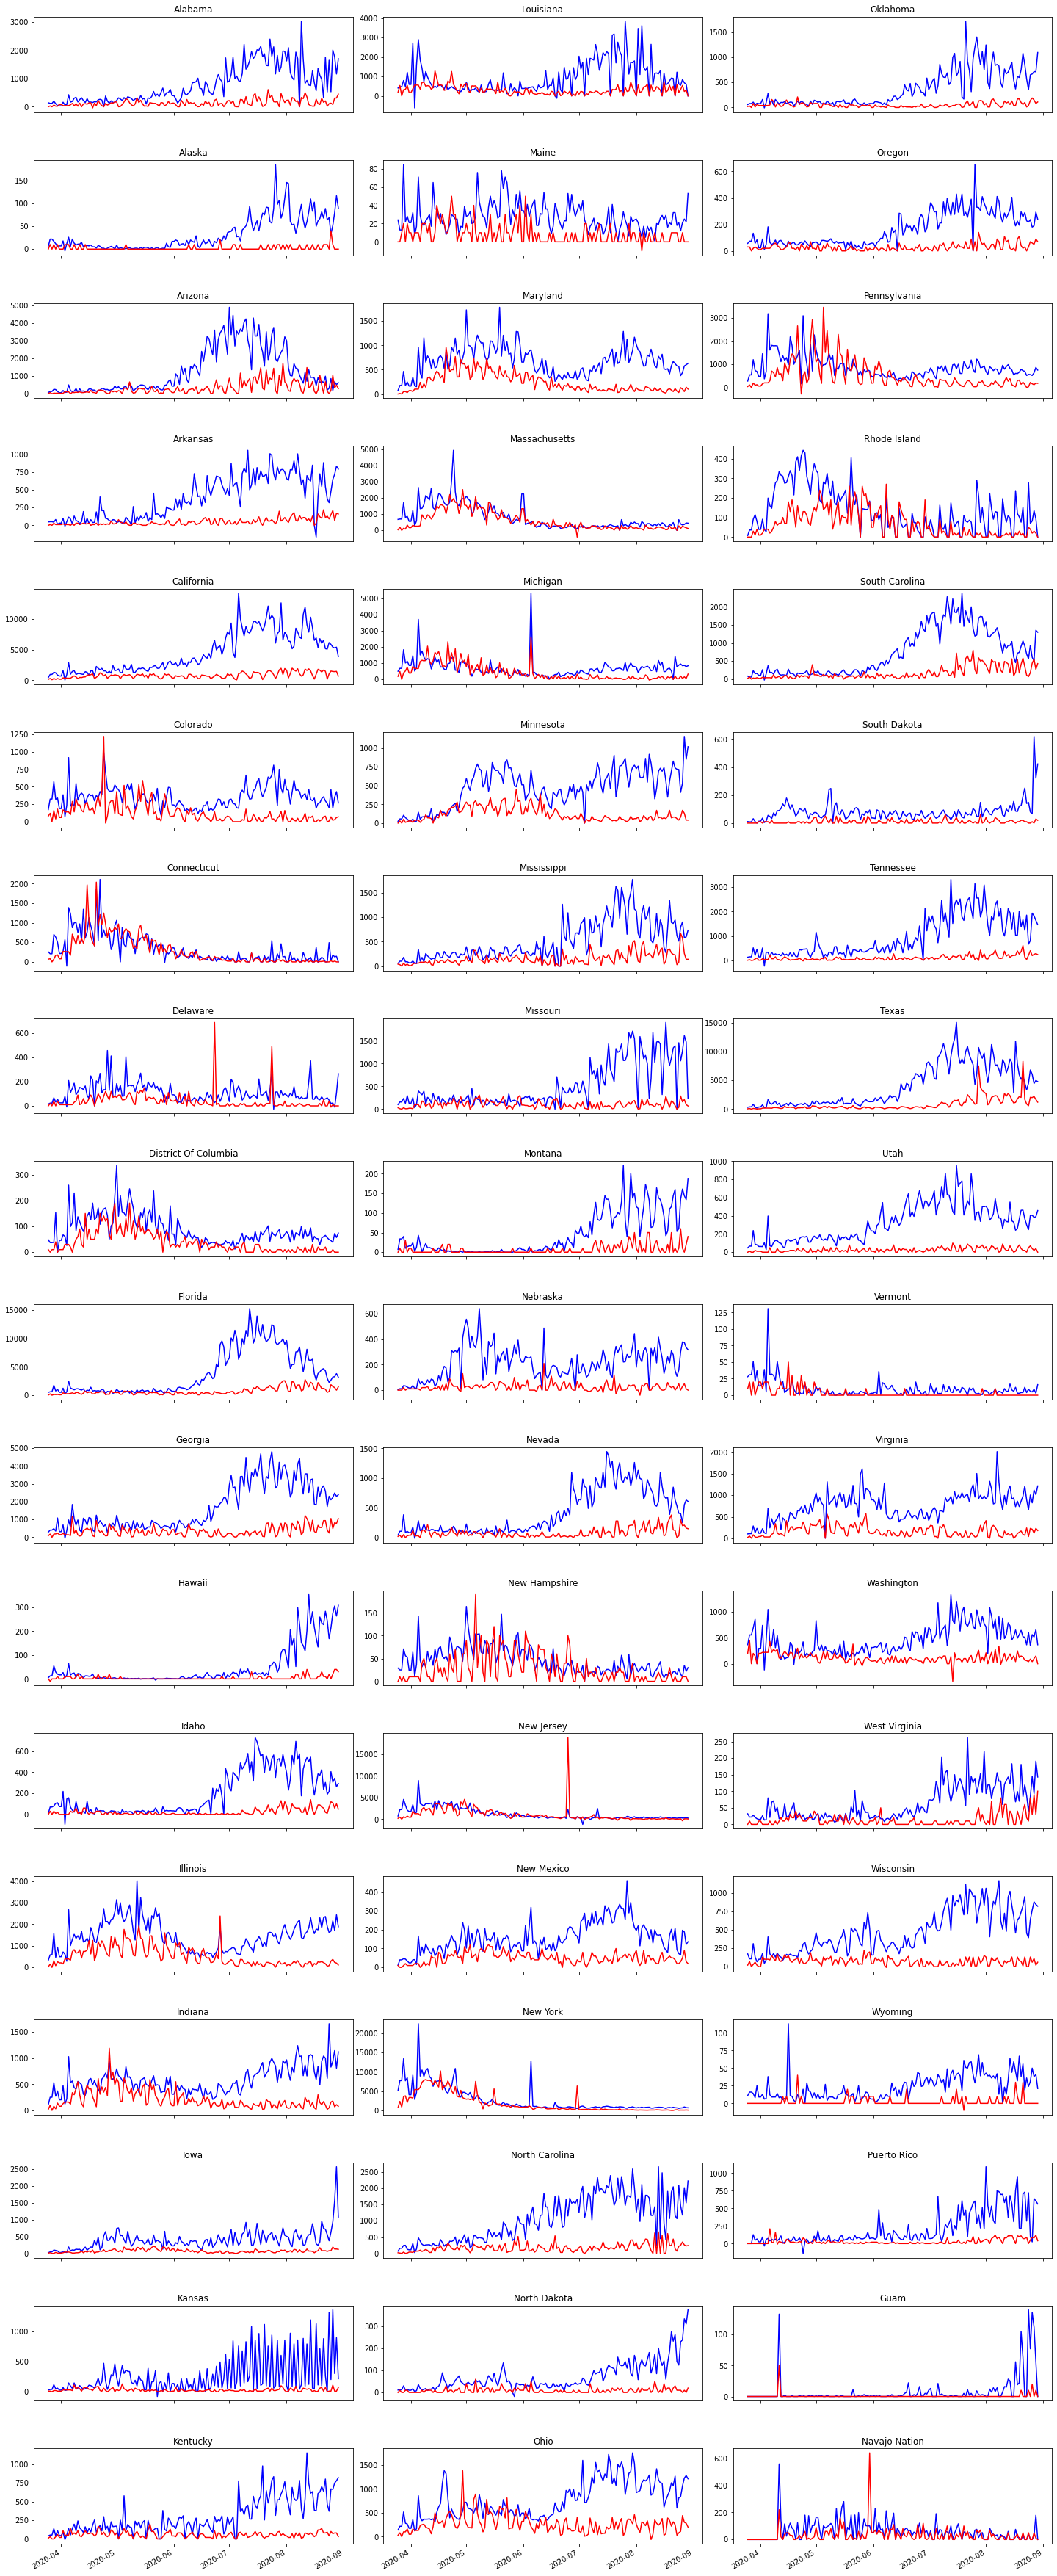

In [4]:
# Plot raw cases
# Get list of states
states = covid['state'].unique()

fig, axs = plt.subplots(18,3,figsize=(20,60))
fig.tight_layout()
plt.subplots_adjust(hspace = 0.5)

fig.autofmt_xdate()

states_s = states[0:18]
rows = range(0,len(states_s))
for row in rows:
    state = states_s[row]
    x = covid[(covid.state == state)]['date']
    y = covid[(covid.state == state)]['cases']
    x2 = covid[(covid.state == state)]['date']
    y2 = covid[(covid.state == state)]['deaths']*10
    axs[row,0].plot(x,y,'b')
    axs[row,0].plot(x2,y2,'r')
    axs[row,0].set_title(state)

states_s = states[18:36]
rows = range(0,len(states_s))
for row in rows:
    state = states_s[row]
    x = covid[(covid.state == state)]['date']
    y = covid[(covid.state == state)]['cases']
    x2 = covid[(covid.state == state)]['date']
    y2 = covid[(covid.state == state)]['deaths']*10
    axs[row,1].plot(x,y,'b')
    axs[row,1].plot(x2,y2,'r')
    axs[row,1].set_title(state)
    
states_s = states[36:54]
rows = range(0,len(states_s))
for row in rows:
    state = states_s[row]
    x = covid[(covid.state == state)]['date']
    y = covid[(covid.state == state)]['cases']
    x2 = covid[(covid.state == state)]['date']
    y2 = covid[(covid.state == state)]['deaths']*10
    axs[row,2].plot(x,y,'b')
    axs[row,2].plot(x2,y2,'r')
    axs[row,2].set_title(state)

plt.savefig('covid_raw.png')
plt.show()

In [5]:
# Calculate 7 day average 

states = covid['state'].unique()
covidaverage = pd.DataFrame(columns = ['state','cases_average','deaths_average','date'])


# average for each state
for state in states:
    stateall = covid[(covid.state == state)].reset_index()
    for d in range(7,len(stateall)):
        cases_av = stateall[d-7:d].cases.mean()
        deaths_av = stateall[d-7:d].deaths.mean()
        date = stateall.iloc[d].date
        state = stateall.iloc[d].state
        covidaverage = covidaverage.append({'state': state,'cases_average':cases_av,'deaths_average':deaths_av,'date':date},ignore_index=True)
        
  



 



In [6]:
statestat = covidaverage[(covidaverage.state == 'Florida')]
state_max = statestat.cases_average.max()
date = str(statestat[(statestat.cases_average == state_max)]['date']-timedelta(weeks=3))
date = date[len(date)-44:len(date)-44+10]
statestat2 = statestat.copy()
statestat2['date'] = statestat2['date'].astype(str)
wks_ago = statestat2[(statestat2.date == date)].reset_index(drop=True)
vline = wks_ago.loc[0,'date']
hline = wks_ago.loc[0,'cases_average']

In [7]:
wks_ago

state  cases_average  deaths_average        date
0  Florida    4744.571429            37.0  2020-06-27

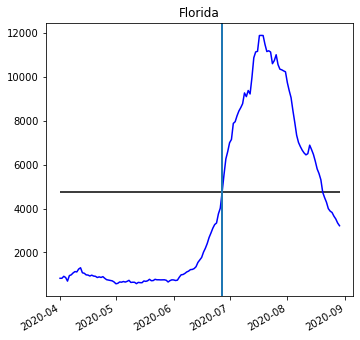

In [8]:
# Plot just Florida


fig, axs = plt.subplots(1,1,figsize=(5,5))
fig.tight_layout()


fig.autofmt_xdate()

state = 'Florida'

x = covidaverage[(covidaverage.state == state)]['date']
y = covidaverage[(covidaverage.state == state)]['cases_average']
axs.plot(x,y,'b')
axs.set_title(state)


plt.hlines(y = hline, xmin = min(x), xmax = max(x))
plt.axvline(pd.to_datetime(vline), linewidth=2)

plt.show()

In [9]:
states = covidaverage['state'].unique()
covid_temp = covidaverage.drop('deaths_average',axis='columns')
lines = pd.DataFrame(columns = ['state','cases_average','date'])

# make a dateframe with values for verticle and horizontal lines for 3 weeks before the peaks
rows = range(0,len(states))
# Get 3 weeks before peaks
for row in rows:
    state = states[row]
    statestat = covid_temp[(covid_temp.state == state)]
    state_max = statestat.cases_average.max()
    date = str(statestat[(statestat.cases_average == state_max)]['date']-timedelta(weeks=3))
    date = date[len(date)-44:len(date)-44+10]
    statestat2 = statestat.copy()
    statestat2['date'] = statestat2['date'].astype(str)
    wks_ago = statestat2[(statestat2.date == date)].reset_index(drop=True)
    lines = lines.append(wks_ago)
    
lines.columns=['state','horizontal','vertical']

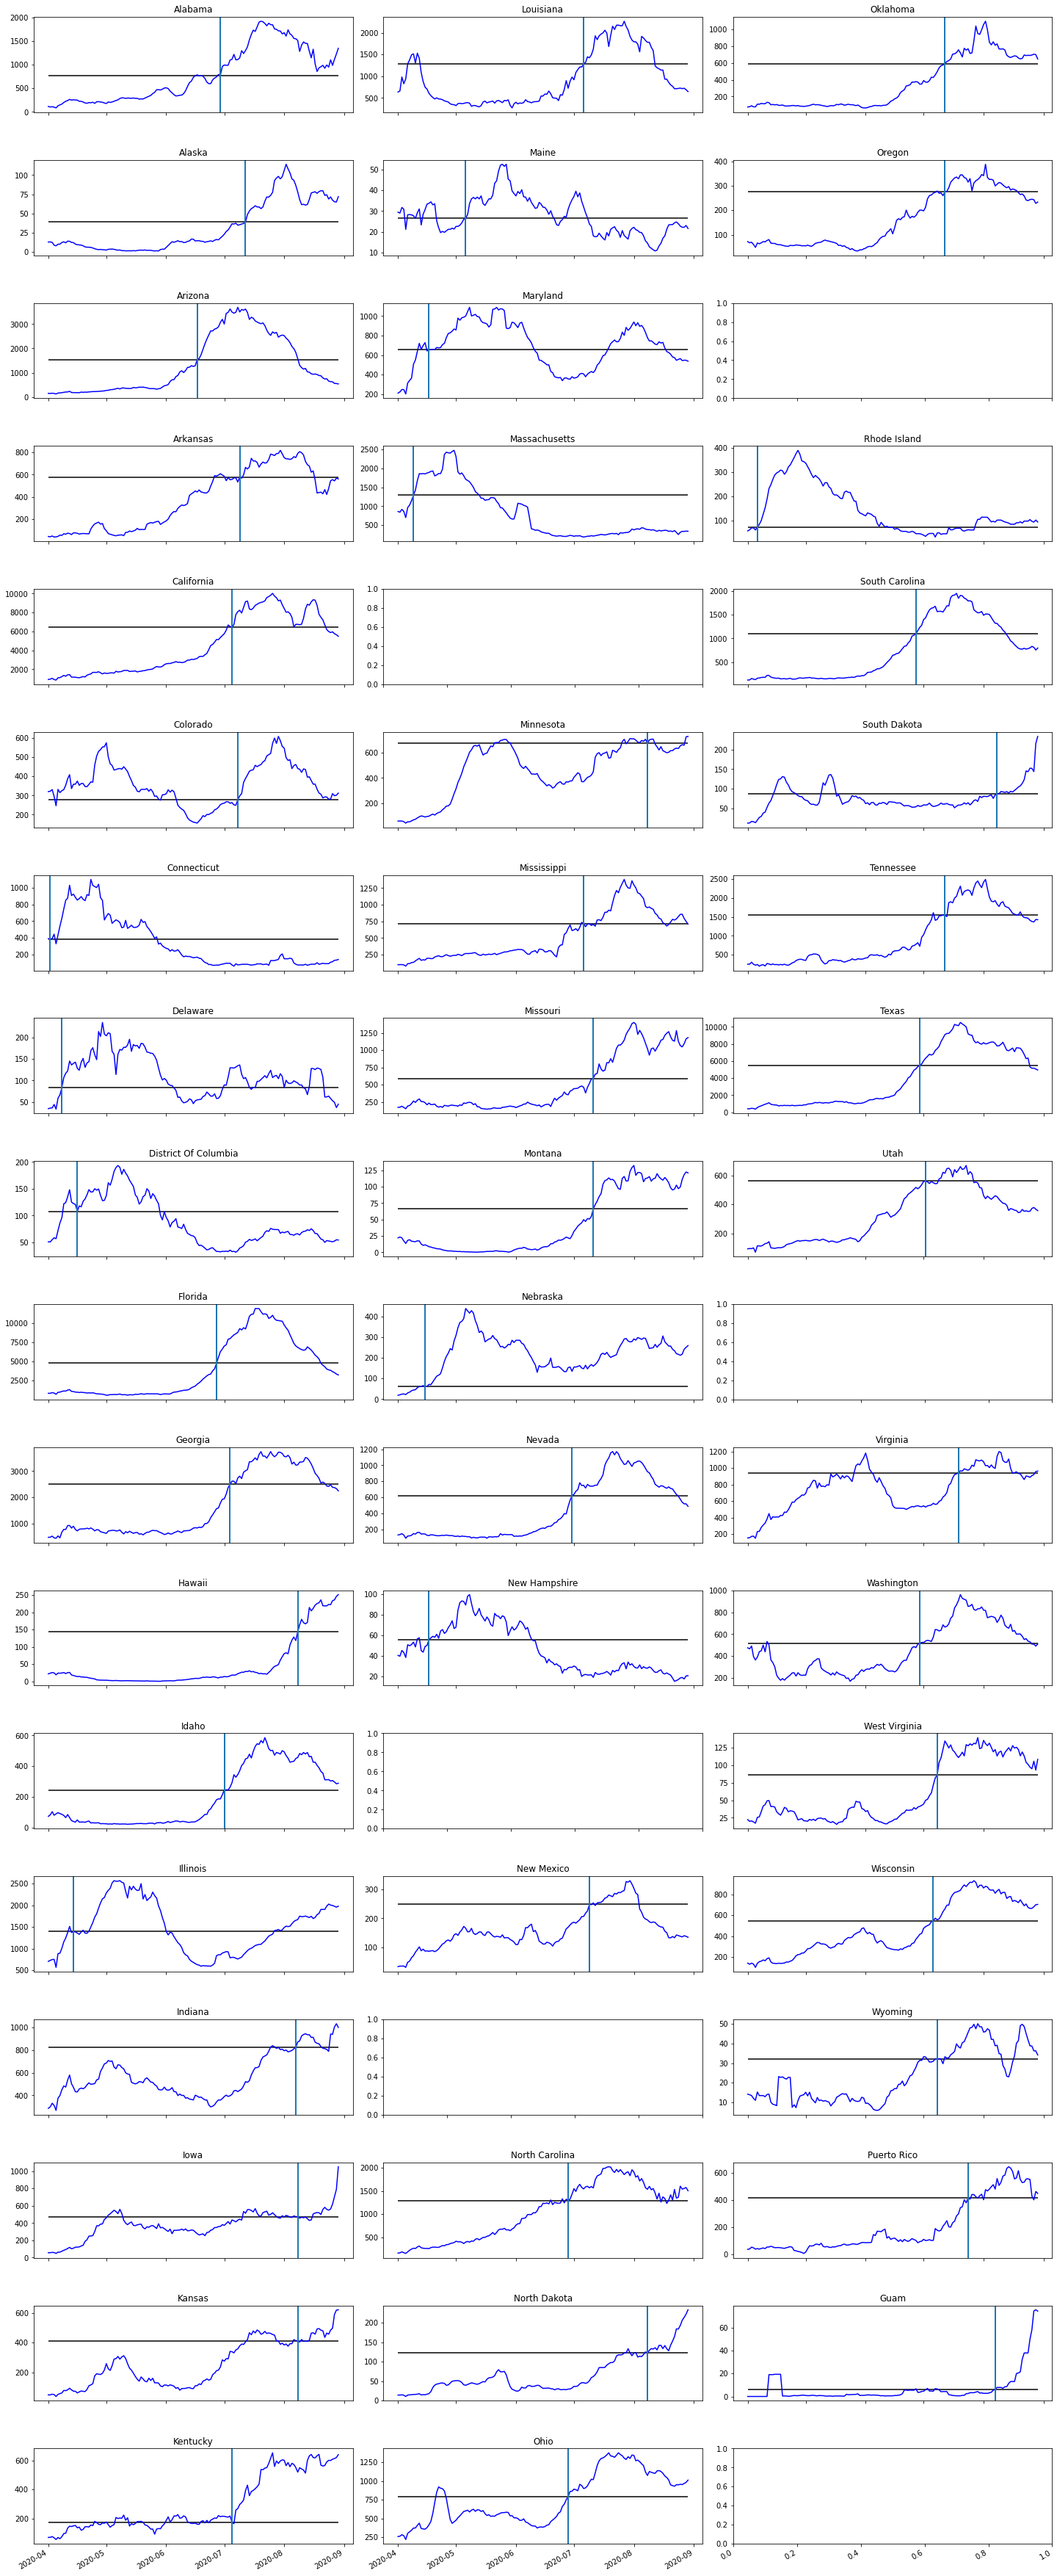

In [10]:
states = covidaverage['state'].unique()

fig, axs = plt.subplots(18,3,figsize=(20,60))
fig.tight_layout()
plt.subplots_adjust(hspace = 0.5)

fig.autofmt_xdate()

states_s = states[0:18]
rows = range(0,len(states_s))
for row in rows:
    try:
        state = states_s[row]
        x = covidaverage[(covidaverage.state == state)]['date']
        y = covidaverage[(covidaverage.state == state)]['cases_average']
        vline = lines[(lines.state == state)].loc[0,'vertical']
        hline = lines[(lines.state == state)].loc[0,'horizontal']
        axs[row,0].plot(x,y,'b')
        axs[row,0].set_title(state)
        axs[row,0].hlines(y = hline, xmin = min(x), xmax = max(x))
        axs[row,0].axvline(pd.to_datetime(vline), linewidth=2)
    except KeyError:
        pass

states_s = states[18:36]
rows = range(0,len(states_s))
for row in rows:
    try:
        state = states_s[row]
        x = covidaverage[(covidaverage.state == state)]['date']
        y = covidaverage[(covidaverage.state == state)]['cases_average']
        vline = lines[(lines.state == state)].loc[0,'vertical']
        hline = lines[(lines.state == state)].loc[0,'horizontal']
        axs[row,1].plot(x,y,'b')
        axs[row,1].set_title(state)
        axs[row,1].hlines(y = hline, xmin = min(x), xmax = max(x))
        axs[row,1].axvline(pd.to_datetime(vline), linewidth=2)
    except KeyError:
        pass
    
states_s = states[36:54]
rows = range(0,len(states_s))
for row in rows:
    try:
        state = states_s[row]
        x = covidaverage[(covidaverage.state == state)]['date']
        y = covidaverage[(covidaverage.state == state)]['cases_average']
        vline = lines[(lines.state == state)].loc[0,'vertical']
        hline = lines[(lines.state == state)].loc[0,'horizontal']
        axs[row,2].plot(x,y,'b')
        axs[row,2].set_title(state)
        axs[row,2].hlines(y = hline, xmin = min(x), xmax = max(x))
        axs[row,2].axvline(pd.to_datetime(vline), linewidth=2)
    except KeyError:
        pass
    
plt.savefig('3wks_beforepeak.png')
plt.show()





###  Include % positive PCR tests from covid tracking project
CSV file downloaded 9/25/20: https://covidtracking.com/data/download <br>

column description:
https://covidtracking.com/about-data/data-definitions

Goal: to get % average tests as in these plots and use it for the predictions:
https://coronavirus.jhu.edu/testing/individual-states/north-carolina

In [11]:
data_csv = pd.read_csv('all-states-history.csv')

In [12]:
viral_data = data_csv[['date','state','positiveIncrease','totalTestResultsIncrease']]

In [13]:
state = 'NC'
st_viral = viral_data[(viral_data.state==state)].reset_index(drop=True)
st_viral['date'] = pd.to_datetime(st_viral['date'], format = '%Y-%m-%d')
st_viral['percent'] = st_viral['positiveIncrease']/st_viral['totalTestResultsIncrease']

They used 'totalTestResultsIncrease' for total tests
and 'positiveIncrease' as positive tests

Need to remove negative data

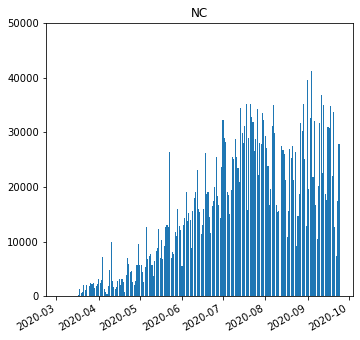

In [14]:
# Plot just NC
st_viral = st_viral.sort_values(by=['date']).reset_index(drop=True)


st_case = st_viral['totalTestResultsIncrease']
date = st_viral['date']

    
    
fig, axs = plt.subplots(1,1,figsize=(5,5))
fig.tight_layout()


fig.autofmt_xdate()


x = date
y = st_case
axs.bar(x,y)
axs.set_title(state)

axs.set_ylim([0,50000])


plt.show()

In [15]:
# Extract columns of interest
data = data_csv[['date','state','positiveIncrease', 'totalTestResultsIncrease']]
# Calculate percent positive
data['percent'] =  data.loc[:,'positiveIncrease']/data.loc[:,'totalTestResultsIncrease']*100

/Users/maayaikeda/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Downloaded state abbreviations from here:https://worldpopulationreview.com/states/state-abbreviations
as state_abb.csv

In [16]:
state_abb = pd.read_csv('state_abb.csv')

In [17]:
# Check to see if all abbrivations included
def Diff(list1, list2): 
    return (list(list(set(list1)-set(list2)) + list(set(list2)-set(list1))))

In [18]:
datacode = sorted(data.state.unique().tolist())
codecode = sorted(state_abb.Code.tolist())
Diff(datacode,codecode)

['MP', 'AS', 'GU', 'PR', 'VI']

In [19]:
state_abb = state_abb.append({'State': 'American Samoa','Abbrev':'ams','Code':'AS'},ignore_index=True)
state_abb = state_abb.append({'State': 'Guam','Abbrev':'GU','Code':'GU'},ignore_index=True)
state_abb = state_abb.append({'State': 'Puerto Rico','Abbrev':'P.R.','Code':'PR'},ignore_index=True)
state_abb = state_abb.append({'State': 'Northern Mariana Islands','Abbrev':'ams','Code':'MP'},ignore_index=True)
state_abb = state_abb.append({'State': 'U.S. Virgin Islands','Abbrev':'ams','Code':'VI'},ignore_index=True)

In [20]:
# add state name

states = []
rows = range(len(data))
for r in rows:
    # Extract state code for row
    code = data.loc[r,'state']
    # Find the row with the country code in state_abb
    row = state_abb[(state_abb.Code == code)]
    # Get state name 
    state_name = row.iloc[0].State
    # Append infomation in categories 
    states.append(state_name)
# Convert to dataframe
states = pd.DataFrame(states)
# Append to videos dataframe and name it data_s
data_s = pd.concat([data,states],axis=1)

data_s = data_s.drop('state', axis='columns')
data_s.columns = ['date','positive','total','percent','state']

In [21]:
# merge with the other data

In [22]:
covid_params = covidaverage
covid_params

state  cases_average  deaths_average       date
0       Alabama     114.285714        3.000000 2020-04-01
1       Alabama     103.285714        4.142857 2020-04-02
2       Alabama     109.142857        4.285714 2020-04-03
3       Alabama     100.857143        4.857143 2020-04-04
4       Alabama      83.714286        4.571429 2020-04-05
...         ...            ...             ...        ...
8601  USA Total   43337.857143     1056.428571 2020-08-25
8602  USA Total   42788.571429     1046.428571 2020-08-26
8603  USA Total   42747.428571     1044.428571 2020-08-27
8604  USA Total   42882.714286     1052.571429 2020-08-28
8605  USA Total   42766.428571      956.714286 2020-08-29

[8606 rows x 4 columns]

In [23]:
covid_params['merge_id'] = covid_params['state'].astype(str) + covid_params['date'].astype(str)
data_s['merge_id'] = data_s['state'].astype(str) + data_s['date'].astype(str)
tests = covid_params.merge(data_s, on='merge_id', how='outer')

In [24]:
covid_params['merge_id'] = covid_params['state'].astype(str) + covid_params['date'].astype(str)
data_s['merge_id'] = data_s['state'].astype(str) + data_s['date'].astype(str)
tests = covid_params.merge(data_s, on='merge_id', how='outer')


tests = tests[['state_x','date_x','cases_average','deaths_average','positive','total','percent']]
tests.columns = ['state','date','cases','deaths','positive','total','percent']


In [25]:
tests.head()

state       date       cases    deaths  positive   total    percent
0  Alabama 2020-04-01  114.285714  3.000000      96.0   495.0  19.393939
1  Alabama 2020-04-02  103.285714  4.142857     156.0   962.0  16.216216
2  Alabama 2020-04-03  109.142857  4.285714     199.0   883.0  22.536806
3  Alabama 2020-04-04  100.857143  4.857143     148.0  1234.0  11.993517
4  Alabama 2020-04-05   83.714286  4.571429     216.0  2225.0   9.707865

In [26]:
# Calculate 7 day average 

states = tests['state'].unique()
covidperav = pd.DataFrame(columns = ['state','date','cases','deaths','positive','total','percent', 'percentav'])


# average for each state
for state in states:
    stateall = tests[(tests.state == state)].reset_index()
    for d in range(7,len(stateall)):
        percentav = stateall[d-7:d].percent.mean()
        date = stateall.iloc[d].date
        state = stateall.iloc[d].state
        cases = stateall.iloc[d].cases
        deaths = stateall.iloc[d].deaths
        positive = stateall.iloc[d].positive
        total = stateall.iloc[d].total
        percent = stateall.iloc[d].percent
        covidperav = covidperav.append({'state': state,'date':date,'cases':cases,'deaths':deaths,'positive':positive,'total':total,'percent':percent,'percentav':percentav},ignore_index=True)
        
  



In [27]:
covidperav

state       date         cases       deaths  positive   total  \
0       Alabama 2020-04-08    165.142857     6.142857     250.0  4206.0   
1       Alabama 2020-04-09    198.714286     5.428571     400.0  1705.0   
2       Alabama 2020-04-10    224.000000     6.428571     199.0   199.0   
3       Alabama 2020-04-11    239.285714     6.142857     223.0   223.0   
4       Alabama 2020-04-12    264.142857     7.428571     334.0   334.0   
...         ...        ...           ...          ...       ...     ...   
8202  USA Total 2020-08-25  43337.857143  1056.428571       NaN     NaN   
8203  USA Total 2020-08-26  42788.571429  1046.428571       NaN     NaN   
8204  USA Total 2020-08-27  42747.428571  1044.428571       NaN     NaN   
8205  USA Total 2020-08-28  42882.714286  1052.571429       NaN     NaN   
8206  USA Total 2020-08-29  42766.428571   956.714286       NaN     NaN   

         percent  percentav  
0       5.943890  27.149137  
1      23.460411  25.227701  
2     100.000000  26.262586  
3     100.000000  37.328757  
4     100.000000  49.901111  
...          ...        ...  
8202         NaN        NaN  
8203         NaN        NaN  
8204         NaN        NaN  
8205         NaN        NaN  
8206         NaN        NaN  

[8207 rows x 8 columns]

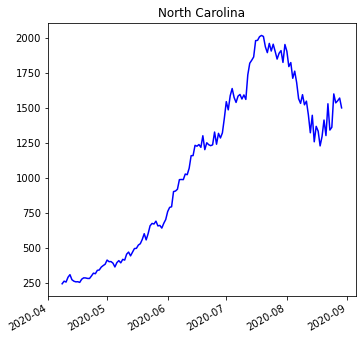

In [28]:
# Plot just North Carolina

state = 'North Carolina'

st_case = covidperav[(covidperav.state == state)]['cases'].reset_index(drop=True)

date = covidperav[(covidperav.state == state)]['date'].reset_index(drop=True)

    
    
fig, axs = plt.subplots(1,1,figsize=(5,5))
fig.tight_layout()


fig.autofmt_xdate()


x = date
y = st_case
axs.plot(x,y,'b')
axs.set_title(state)



plt.show()




In [29]:
scaler = RobustScaler()

params = covidperav.copy()
params = params.replace([np.inf, -np.inf], np.nan)
params = params.dropna(axis='rows')
states = params['state'].unique()

covid_scaled = pd.DataFrame(columns = ['cases','deaths','positive','total','percent','percentav','date','state'])

for state in states:
    st_data = params[(params.state == state)].reset_index(drop=True)
    st_params = st_data.drop(['state','date'],axis='columns')
    st_params = st_params.reset_index(drop=True)
    scaler.fit(st_params)
    scaled_temp = scaler.transform(st_params)
    scaler = load(open('scaler' + state +'.pkl', 'rb'))
    scaled_temp = pd.DataFrame(scaled_temp, columns = ['cases','deaths','positive','total','percent','percentav'])
    scaled_temp['date'] = st_data.loc[:,'date']
    scaled_temp['state'] = st_data.loc[:,'state']
    covid_scaled = covid_scaled.append(scaled_temp)
covid_scaled = covid_scaled.reset_index(drop=True)

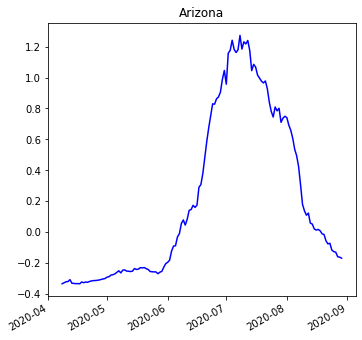

In [30]:
# Plot just Arizona

state = 'Arizona'

st_case = covid_scaled[(covid_scaled.state == state)]['cases'].reset_index(drop=True)

date = covid_scaled[(covid_scaled.state == state)]['date'].reset_index(drop=True)

    
    
fig, axs = plt.subplots(1,1,figsize=(5,5))
fig.tight_layout()


fig.autofmt_xdate()


x = date
y = st_case
axs.plot(x,y,'b')
axs.set_title(state)



plt.show()



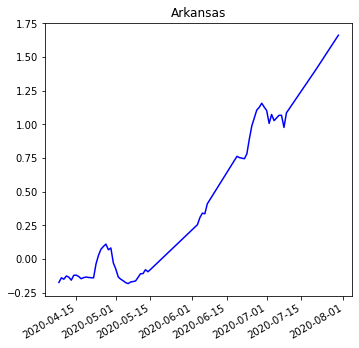

In [31]:
# Plot just Arizona

state = 'Arkansas'

st_case = covid_scaled[(covid_scaled.state == state)]['cases'].reset_index(drop=True)

date = covid_scaled[(covid_scaled.state == state)]['date'].reset_index(drop=True)

    
    
fig, axs = plt.subplots(1,1,figsize=(5,5))
fig.tight_layout()


fig.autofmt_xdate()


x = date
y = st_case
axs.plot(x,y,'b')
axs.set_title(state)



plt.show()



In [32]:
covid_scaled.head()

cases    deaths  positive     total   percent  percentav       date  \
0 -0.399016 -0.740331 -0.280185 -0.268966 -0.541965   0.752904 2020-04-08   
1 -0.359832 -0.850829 -0.106875 -0.712544  0.876177   0.582178 2020-04-09   
2 -0.330318 -0.696133 -0.339110 -0.979648  7.072842   0.674131 2020-04-10   
3 -0.312477 -0.740331 -0.311381 -0.975391  7.072842   1.657395 2020-04-11   
4 -0.283463 -0.541436 -0.183131 -0.955704  7.072842   2.774488 2020-04-12   

     state  
0  Alabama  
1  Alabama  
2  Alabama  
3  Alabama  
4  Alabama

In [33]:
slope_df = pd.DataFrame(columns = ['state','date','cases','deaths','positive','total','percent','slope','death_slope','percentav'])
rows = range(0,len(covid_scaled))


for row in rows:
    try:
        state = covid_scaled.loc[row,'state']
        cases = covid_scaled.loc[row,'cases']
        deaths = covid_scaled.loc[row,'deaths']
        positive = covid_scaled.loc[row,'positive']
        total = covid_scaled.loc[row,'total']
        percent = covid_scaled.loc[row,'percent']
        date = covid_scaled.loc[row,'date']
        percentav = covid_scaled.loc[row,'percentav']
        next_day = date + timedelta(days=7)
        case_nextday = covid_scaled[(covid_scaled.date == next_day)& (covid_scaled.state==state)].reset_index().loc[0,'cases']
        slope = case_nextday - cases
        death_nextday = covid_scaled[(covid_scaled.date == next_day)& (covid_scaled.state==state)].reset_index().loc[0,'deaths']
        death_slope = death_nextday - deaths
        df_toappend = pd.DataFrame({'state': [state],'date':[date],'cases': [cases],'deaths':[deaths],'positive':[death_slope],'total':[death_slope],'percent':[death_slope],'slope':[slope],'death_slope':[death_slope],'percentav':[percentav]})
        slope_df = slope_df.append(df_toappend)
    except KeyError:
        date = covid_scaled.loc[row,'date']
        cases = covid_scaled.loc[row,'cases']
        deaths = covid_scaled.loc[row,'deaths']
        state = covid_scaled.loc[row,'state']
        positive = covid_scaled.loc[row,'positive']
        total = covid_scaled.loc[row,'total']
        percent = covid_scaled.loc[row,'percent']
        percentav = covid_scaled.loc[row,'percentav']
        slope = np.nan
        death_slope = np.nan
        df_toappend = pd.DataFrame({'state': [state],'date':[date],'cases': [cases],'deaths':[deaths],'positive':[death_slope],'total':[death_slope],'percent':[death_slope],'slope':[slope],'death_slope':[death_slope],'percentav':[percentav]})
        slope_df = slope_df.append(df_toappend)
             

slope_df.reset_index(drop=True, inplace=True)

In [34]:
# add later date

later_cases = pd.DataFrame(columns = ['state','date','cases','deaths','positive','total','percent','slope','death_slope','later_date', 'later_case','percentav'])
row = range(0,len(slope_df))

for row in rows:
    try:
        state = slope_df.loc[row,'state']
        cases = slope_df.loc[row,'cases']
        date = slope_df.loc[row,'date']
        slope = slope_df.loc[row,'slope']
        positive = slope_df.loc[row,'positive']
        total = slope_df.loc[row,'total']
        percent = slope_df.loc[row,'percent']
        death_slope = slope_df.loc[row,'death_slope']
        later_date = date + timedelta(weeks=3)
        later_case = slope_df[(slope_df.date == later_date)& (slope_df.state==state)].reset_index().loc[0,'cases']
        df_toappend = pd.DataFrame({'state': [state],'date':[date],'cases': [cases],'deaths': [deaths],'positive':[positive],'total':[total],'percent':[percent],'slope':[slope],'death_slope':[death_slope],'later_date': [later_date], 'later_case': [later_case],'percentav':[percentav]})
        later_cases = later_cases.append(df_toappend)
    except KeyError:
        date = slope_df.loc[row,'date']
        cases = slope_df.loc[row,'cases']
        state = slope_df.loc[row,'state']
        positive = slope_df.loc[row,'positive']
        total = slope_df.loc[row,'total']
        percent = slope_df.loc[row,'percent']
        death_slope = slope_df.loc[row,'death_slope']
        slope = slope_df.loc[row,'slope']
        later_date = date + timedelta(weeks=3)
        later_case = np.nan
        df_toappend = pd.DataFrame({'state': [state],'date':[date],'cases': [cases],'deaths': [deaths],'positive':[positive],'total':[total],'percent':[percent],'slope':[slope],'death_slope':[death_slope],'later_date': [later_date], 'later_case': [later_case],'percentav':[percentav]})
        later_cases = later_cases.append(df_toappend)
        
wkslater = later_cases.copy()
wkslater.reset_index(drop=True, inplace=True)


nullrows=[]
rows = range(len(covid_scaled_test))
for r in rows:
    row = covid_scaled_test.iloc[r]
    if row.isnull().values.any() == True:
        nullrows.append(row)
    else:
        pass

# KNN

'cases','later_case','slope','deaths','death_slope','positive','total','percent','percentav'

In [35]:
cutoff = wkslater.iloc[-1]['date']- timedelta(weeks=3)
cutoff

Timestamp('2020-08-08 00:00:00')

In [73]:
# Sort by date and everything prior to 8/8/2020
covid_scaled_test = wkslater[(wkslater.date <cutoff)]
covid_scaled_test = covid_scaled_test.dropna(axis='rows')
st_wksKNN = covid_scaled_test[['cases','later_case','slope','deaths','death_slope','positive','total','percent','percentav']]
from sklearn.model_selection import train_test_split
# Shuffle data
st_wksKNN = shuffle(st_wksKNN)
train , test = train_test_split(st_wksKNN, test_size = 0.3)

x_train = train.drop('later_case', axis=1)
y_train = train['later_case']

x_test = test.drop('later_case', axis = 1)
y_test = test['later_case']




In [74]:
rmse_val = [] #to store rmse values for different k
acc_val =[]
for K in range(30):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    acc = model.score(x_test, y_test)
    acc_val.append(acc)
    
    print('RMSE value for k= ' , K , 'is:', error,'acc:',acc)

RMSE value for k=  1 is: 0.686668957665484 acc: 0.3019452063078706
RMSE value for k=  2 is: 0.5687664238887268 acc: 0.5210804277602739
RMSE value for k=  3 is: 0.5345757574665266 acc: 0.57692905109382
RMSE value for k=  4 is: 0.5283553725474364 acc: 0.5867175719557027
RMSE value for k=  5 is: 0.5252688925062157 acc: 0.5915319913668178
RMSE value for k=  6 is: 0.5195739333330861 acc: 0.6003411871990614
RMSE value for k=  7 is: 0.5384138893296083 acc: 0.5708321365567317
RMSE value for k=  8 is: 0.5434660265873682 acc: 0.5627402667943563
RMSE value for k=  9 is: 0.5567810073557122 acc: 0.5410519706593057
RMSE value for k=  10 is: 0.5648370555712882 acc: 0.5276748779759729
RMSE value for k=  11 is: 0.5722039229890126 acc: 0.5152739651307552
RMSE value for k=  12 is: 0.5764287805504198 acc: 0.5080896076592913
RMSE value for k=  13 is: 0.580038148444862 acc: 0.5019100263142309
RMSE value for k=  14 is: 0.5849472582179865 acc: 0.49344325337187245
RMSE value for k=  15 is: 0.5857741040203818 a

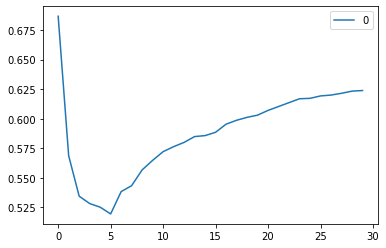

In [75]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val)  
curve.plot()

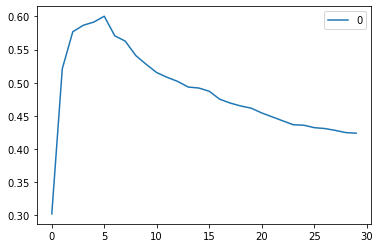

In [76]:
#plotting the rmse values against k values
curve = pd.DataFrame(acc_val) #elbow curve 
curve.plot()

In [77]:
model = neighbors.KNeighborsRegressor(n_neighbors = 6)

model.fit(x_train, y_train)  #fit the model
pred=model.predict(x_test) #make prediction on test set
error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
rmse_val.append(error) #store rmse values
acc = model.score(x_test, y_test)
acc

0.6003411871990614

In [101]:
best = 0
for _ in range(30):
    train , test = train_test_split(st_wksKNN, test_size = 0.3)
    x_train = train.drop('later_case', axis=1)
    y_train = train['later_case']
    x_test = test.drop('later_case', axis = 1)
    y_test = test['later_case']

    model = neighbors.KNeighborsRegressor(n_neighbors = 6)

    model.fit(x_train, y_train)
    acc = model.score(x_test, y_test)
    print("Accuracy: " + str(acc))
    
    # If the current model has a better score than one we've already trained then save it
    if acc > best:
        best = acc
        with open("covid_knn_model.pickle", "wb") as f:
            pickle.dump(model, f)

Accuracy: 0.534339078067567
Accuracy: 0.5287685583561702
Accuracy: 0.5614091837309871
Accuracy: 0.49752765591709003
Accuracy: 0.4976554450736018
Accuracy: 0.43100898120917497
Accuracy: 0.5137168251403158
Accuracy: 0.5476551802075003
Accuracy: 0.5240373694953329
Accuracy: 0.5729866697354651
Accuracy: 0.4561143784383376
Accuracy: 0.5478145931347351
Accuracy: 0.5549158427584808
Accuracy: 0.49917467442680785
Accuracy: 0.547290320506665
Accuracy: 0.5155957543116038
Accuracy: 0.5105141713416588
Accuracy: 0.5247168219421343
Accuracy: 0.5566765340102624
Accuracy: 0.4683676571582229
Accuracy: 0.5413695163823246
Accuracy: 0.5109483635769205
Accuracy: 0.5183903719113053
Accuracy: 0.545419894448663
Accuracy: 0.5122191651049531
Accuracy: 0.5107923208406
Accuracy: 0.49083870268386276
Accuracy: 0.5647587758300832
Accuracy: 0.4846751230971015
Accuracy: 0.5122015505933404


In [102]:
x_train.head()

cases     slope    deaths  death_slope  positive     total   percent  \
4431  0.030797  0.318841  0.571429     0.400000  0.400000  0.400000  0.400000   
273  -0.251953  0.016406  0.571429    -0.064034 -0.064034 -0.064034 -0.064034   
5129  1.827947 -0.640684  0.571429     0.452830  0.452830  0.452830  0.452830   
6848 -0.154123  0.038107  0.571429    -0.307692 -0.307692 -0.307692 -0.307692   
2565  1.552234  0.011322  0.571429     0.720930  0.720930  0.720930  0.720930   

      percentav  
4431   2.084793  
273    2.084793  
5129   2.084793  
6848   2.084793  
2565   2.084793

In [103]:
state = 'Florida'

fl_wks = wkslater[(wkslater.state == state)].reset_index(drop=True)
fl_wks_resultdate = fl_wks[['date']]


fl_wks_param = fl_wks[['cases','slope','deaths','death_slope','positive','total','percent','percentav']]
fl_wks_param = fl_wks_param.dropna(axis='rows')

fl_wks_result = fl_wks[['later_case']]
x_test = fl_wks_param.values

pickle_in = open("covid_knn_model.pickle", "rb")
model = pickle.load(pickle_in)


predictions = model.predict(x_test) # Gets a list of all predictions


diff = len(fl_wks_result)-len(predictions)
addnon = [[]]*diff
addnon[0].append(np.nan)

predictions =np.append(predictions,addnon)
predictions = pd.DataFrame(predictions, columns=['prediction'])
predictions = predictions.reset_index(drop=True)
fl_wks_result = pd.concat([fl_wks,predictions], axis=1)

In [104]:
state = 'Vermont'


st_wks = wkslater[(wkslater.state == state)].reset_index(drop=True)
st_wks_resultdate = st_wks[['date']]


st_wks_param = st_wks[['cases','slope','deaths','death_slope','positive','total','percent','percentav']]
st_wks_param = st_wks_param.dropna(axis='rows')

st_wks_result = st_wks[['later_case']]
x_test = st_wks_param.values

pickle_in = open("covid_knn_model.pickle", "rb")
model = pickle.load(pickle_in)


predictions = model.predict(x_test) # Gets a list of all predictions


diff = len(st_wks_result)-len(predictions)
addnon = [[]]*diff
addnon[0].append(np.nan)

predictions =np.append(predictions,addnon)
predictions = pd.DataFrame(predictions, columns=['prediction'])
predictions = predictions.reset_index(drop=True)
st_wks_result = pd.concat([st_wks,predictions], axis=1)

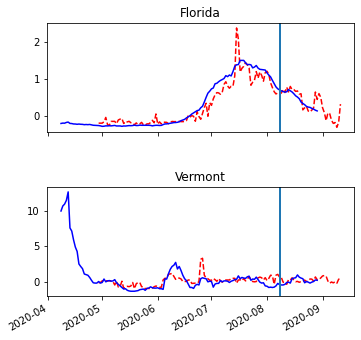

In [105]:
fig, axs = plt.subplots(2,figsize=(5,5))

fig.tight_layout()
plt.subplots_adjust(hspace = 0.5)

fig.autofmt_xdate()
vline = '2020-08-08'

# prediction
x = fl_wks_result['later_date']
y = fl_wks_result['prediction']
# actual
x2 = fl_wks_result['date']
y2 = fl_wks_result['cases']
axs[0].plot(x,y,linestyle = '--',c='r')
axs[0].plot(x2,y2,'b')
axs[0].set_title('Florida')
axs[0].axvline(pd.to_datetime(vline), linewidth=2)


# prediction
x = st_wks_result['later_date']
y = st_wks_result['prediction']
# actual
x2 = st_wks_result['date']
y2 = st_wks_result['cases']
axs[1].plot(x,y,linestyle = '--',c='r')
axs[1].plot(x2,y2,'b')
axs[1].set_title(state)
axs[1].axvline(pd.to_datetime(vline), linewidth=2)

In [106]:
states = wkslater['state'].unique()

prediction_allstates = pd.DataFrame(columns=['cases','slope','deaths','death_slope','percentav'])

for state in states:
    try:
        state = state
        st_wks = wkslater[(wkslater.state == state)].reset_index(drop=True)
        st_wks_resultdate = st_wks[['date']]
        st_wks_param = st_wks[['cases','slope','deaths','death_slope','positive','total','percent','percentav']]
        st_wks_param = st_wks_param.dropna(axis='rows')
        st_wks_result = st_wks[['later_case']]
        x_test = st_wks_param.values
        pickle_in = open("covid_knn_model.pickle", "rb")
        model = pickle.load(pickle_in)
        predictions = model.predict(x_test) # Gets a list of all predictions
        # Add NaN to make the length the same
        diff = len(st_wks_result)-len(predictions)
        addnon = [[]]*diff
        addnon[0].append(np.nan)
        predictions =np.append(predictions,addnon)
        predictions = pd.DataFrame(predictions, columns=['prediction'])
        predictions = predictions.reset_index(drop=True)
        st_wks_result = pd.concat([st_wks,predictions], axis=1)
        prediction_allstates = prediction_allstates.append(st_wks_result)
    except ValueError:
        pass

prediction_allstates = prediction_allstates.sort_values(by=['date'])
prediction_allstates = prediction_allstates.reset_index(drop=True)

    
    
prediction_allstates['later_date'] = pd.to_datetime(prediction_allstates['later_date'], format = '%Y-%m-%d')

In [107]:
populations = pd.read_csv('Active 21 per 100 000-Population Table.csv')
populations.columns = ['state','population']

In [108]:
populations.head()

state  population
0     Alabama   4,903,185
1      Alaska     731,545
2     Arizona   7,278,717
3    Arkansas   3,017,825
4  California  39,512,223

In [109]:
tounscale = prediction_allstates[['state','later_date','prediction','deaths','positive','total','percent','percentav']]

In [110]:

covid_unscaled = pd.DataFrame(columns = ['state','later_date','prediction','deaths','positive','total','percent','percentav'])

for state in states:
    st_data = tounscale[(tounscale.state == state)].reset_index(drop=True)
    st_params = st_data.drop(['state','later_date'],axis='columns')
    st_params = st_params.reset_index(drop=True)
    scaler = load(open('scaler' + state +'.pkl', 'rb'))
    unscaled_temp = scaler.inverse_transform(st_params)
    unscaled_temp = pd.DataFrame(unscaled_temp, columns = ['prediction','deaths','positive','total','percent','percentav'])
    unscaled_temp['later_date'] = st_data.loc[:,'later_date']
    unscaled_temp['state'] = st_data.loc[:,'state']
    covid_unscaled = covid_unscaled.append(unscaled_temp)
covid_unscaled = covid_unscaled.reset_index(drop=True)


In [111]:
covid_unscaled.head()

state later_date  prediction     deaths     positive        total  \
0  Alabama 2020-04-29  381.319532  14.622449   626.389503  6594.715470   
1  Alabama 2020-04-30  486.513818  14.622449   836.787293  7965.339779   
2  Alabama 2020-05-01  243.584905  14.622449   760.279006  7466.930939   
3  Alabama 2020-05-02  687.029665  14.622449  1028.058011  9211.361878   
4  Alabama 2020-05-03  290.302507  14.622449   530.754144  5971.704420   

     percent  percentav  
0  14.548866  42.138927  
1  17.551498  42.138927  
2  16.459632  42.138927  
3  20.281165  42.138927  
4  13.184032  42.138927

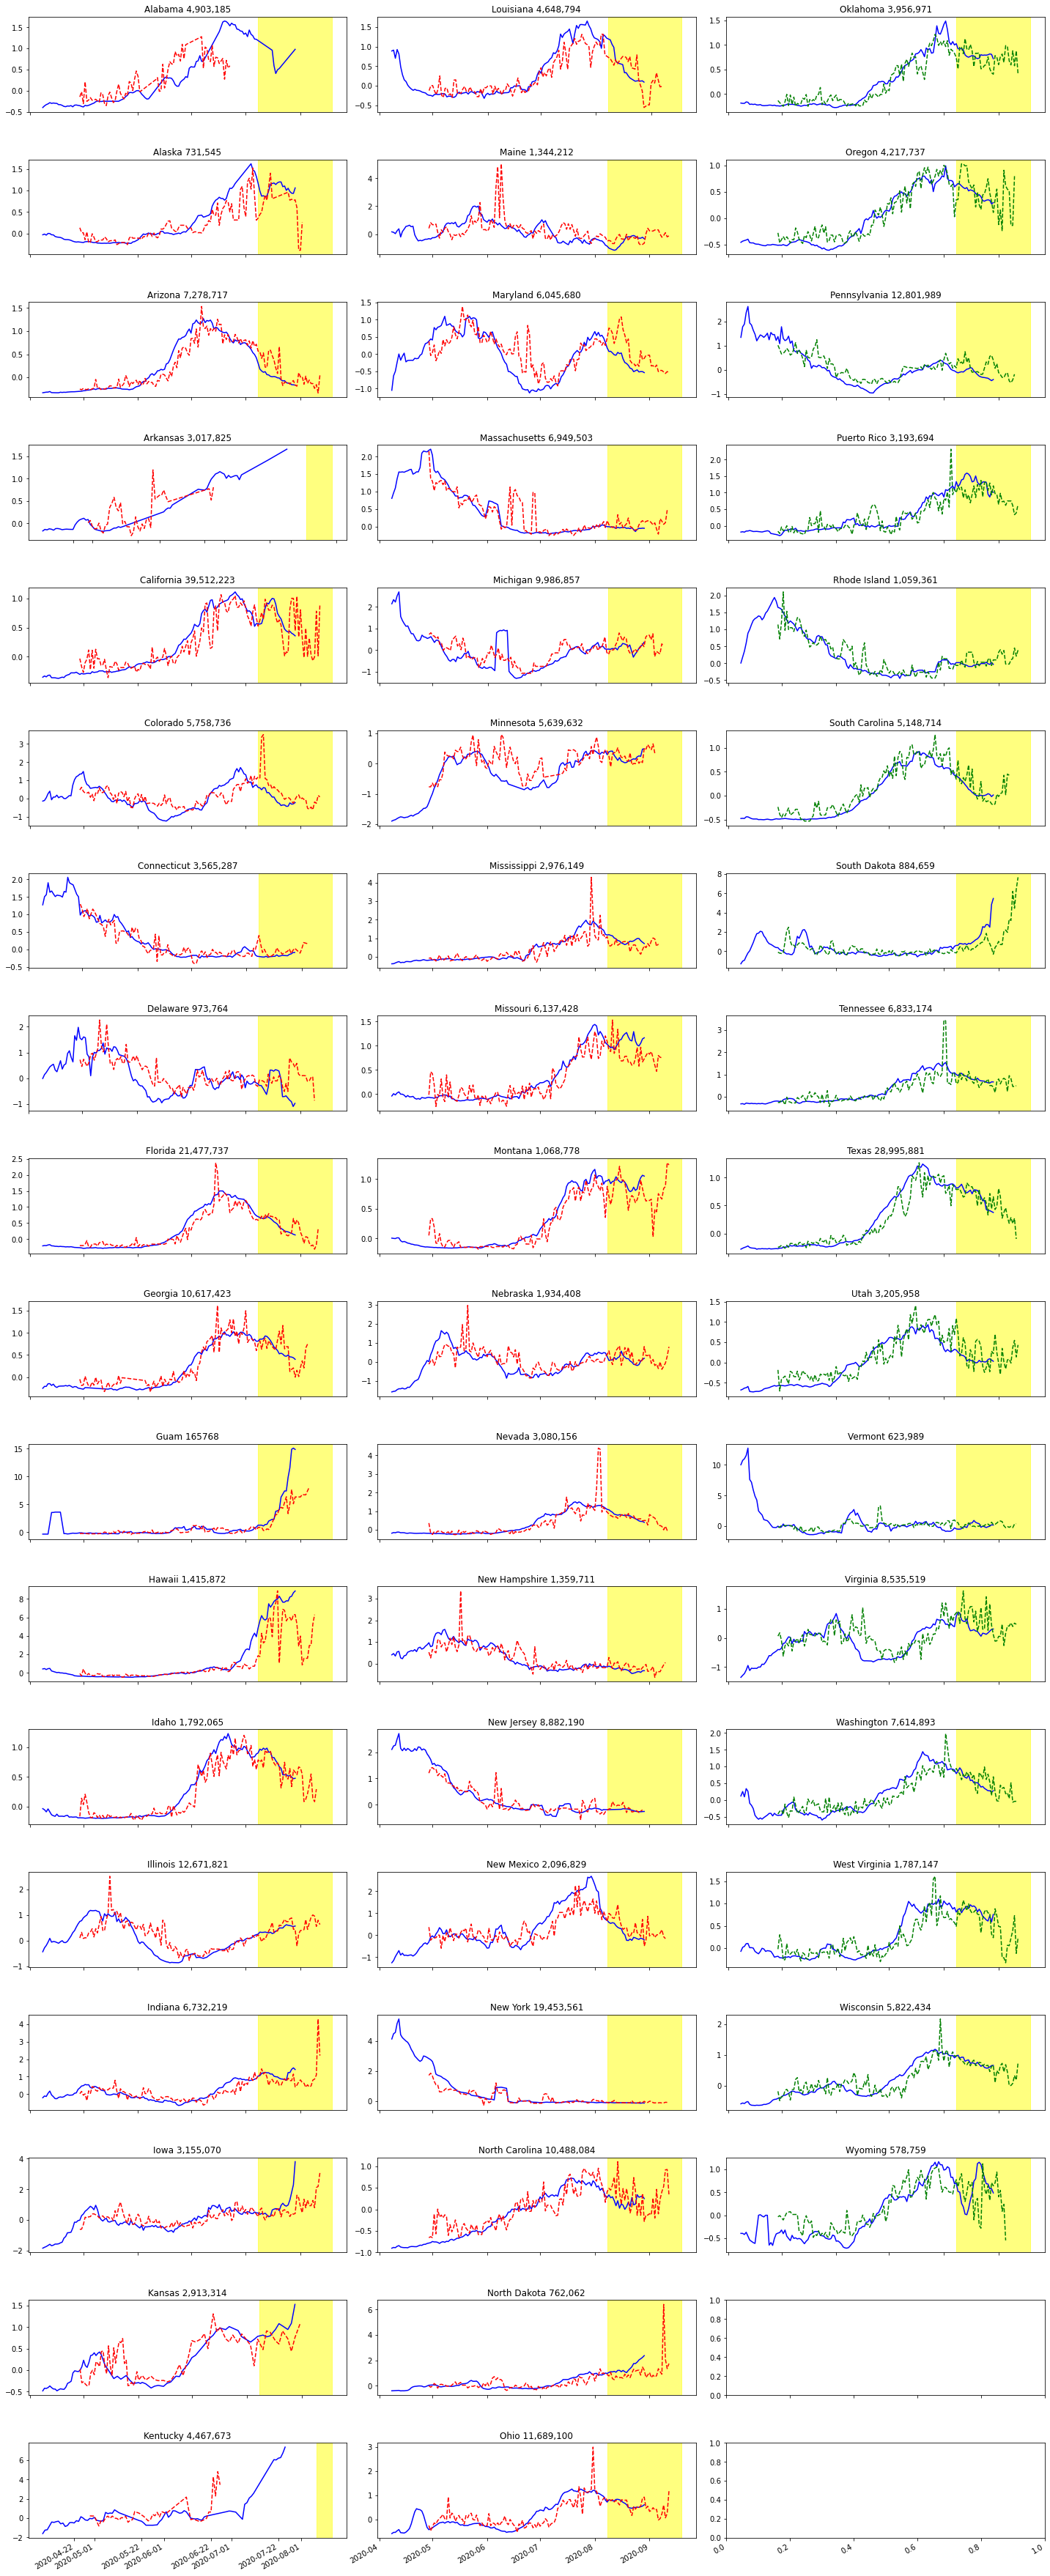

In [112]:
states = sorted(prediction_allstates['state'].unique())

fig, axs = plt.subplots(18,3,figsize=(20,60))
fig.tight_layout()
plt.subplots_adjust(hspace = 0.5)

fig.autofmt_xdate()
vline = wkslater.iloc[-1]['date'] - timedelta(weeks=3)


states_s = states[0:18]
rows = range(0,len(states_s))
for row in rows:
    state = states_s[row]
    if len(prediction_allstates[(prediction_allstates.state == state)])>1:
        try:
            x = prediction_allstates[(prediction_allstates.state == state)]['later_date']
            y = prediction_allstates[(prediction_allstates.state == state)]['prediction']
            x2 = prediction_allstates[(prediction_allstates.state == state)]['date']
            y2 = prediction_allstates[(prediction_allstates.state == state)]['cases']
            population = populations[(populations.state ==state)].iloc[0].population
            population = str(population)
            axs[row,0].plot(x2,y2,'b')
            axs[row,0].plot(x,y,'--',c='r')
            axs[row,0].set_title(state +' '+ population)
            axs[row,0].axvspan(vline, max(x), alpha=0.5, color='yellow')

        except KeyError:
            pass
    else:
        pass

states_s = states[18:36]
rows = range(0,len(states_s))
for row in rows:
    state = states_s[row]
    if len(prediction_allstates[(prediction_allstates.state == state)])>1:
        try:
            
            x = prediction_allstates[(prediction_allstates.state == state)]['later_date']
            y = prediction_allstates[(prediction_allstates.state == state)]['prediction']
            x2 = prediction_allstates[(prediction_allstates.state == state)]['date']
            y2 = prediction_allstates[(prediction_allstates.state == state)]['cases']
            population = populations[(populations.state ==state)].iloc[0].population
            population = str(population)
            axs[row,1].plot(x2,y2,'b')
            axs[row,1].plot(x,y,'--',c='r')
            axs[row,1].set_title(state +' '+ population)
            axs[row,1].axvspan(vline, max(x), alpha=0.5, color='yellow')

        except KeyError:
            pass
    
    
states_s = states[36:54]
rows = range(0,len(states_s))
for row in rows:
    state = states_s[row]
    if len(prediction_allstates[(prediction_allstates.state == state)])>1:
        try:
            
            x = prediction_allstates[(prediction_allstates.state == state)]['later_date']
            y = prediction_allstates[(prediction_allstates.state == state)]['prediction']
            x2 = prediction_allstates[(prediction_allstates.state == state)]['date']
            y2 = prediction_allstates[(prediction_allstates.state == state)]['cases']
            population = populations[(populations.state ==state)].iloc[0].population
            population = str(population)
            axs[row,2].plot(x2,y2,'b')
            axs[row,2].plot(x,y,'--',c='g')
            axs[row,2].set_title(state +' '+ population)
            axs[row,2].axvspan(vline, max(x), alpha=0.5, color='yellow')

        except KeyError:
            pass
    
    
plt.savefig('3wks_beforepeak.png')
plt.show()

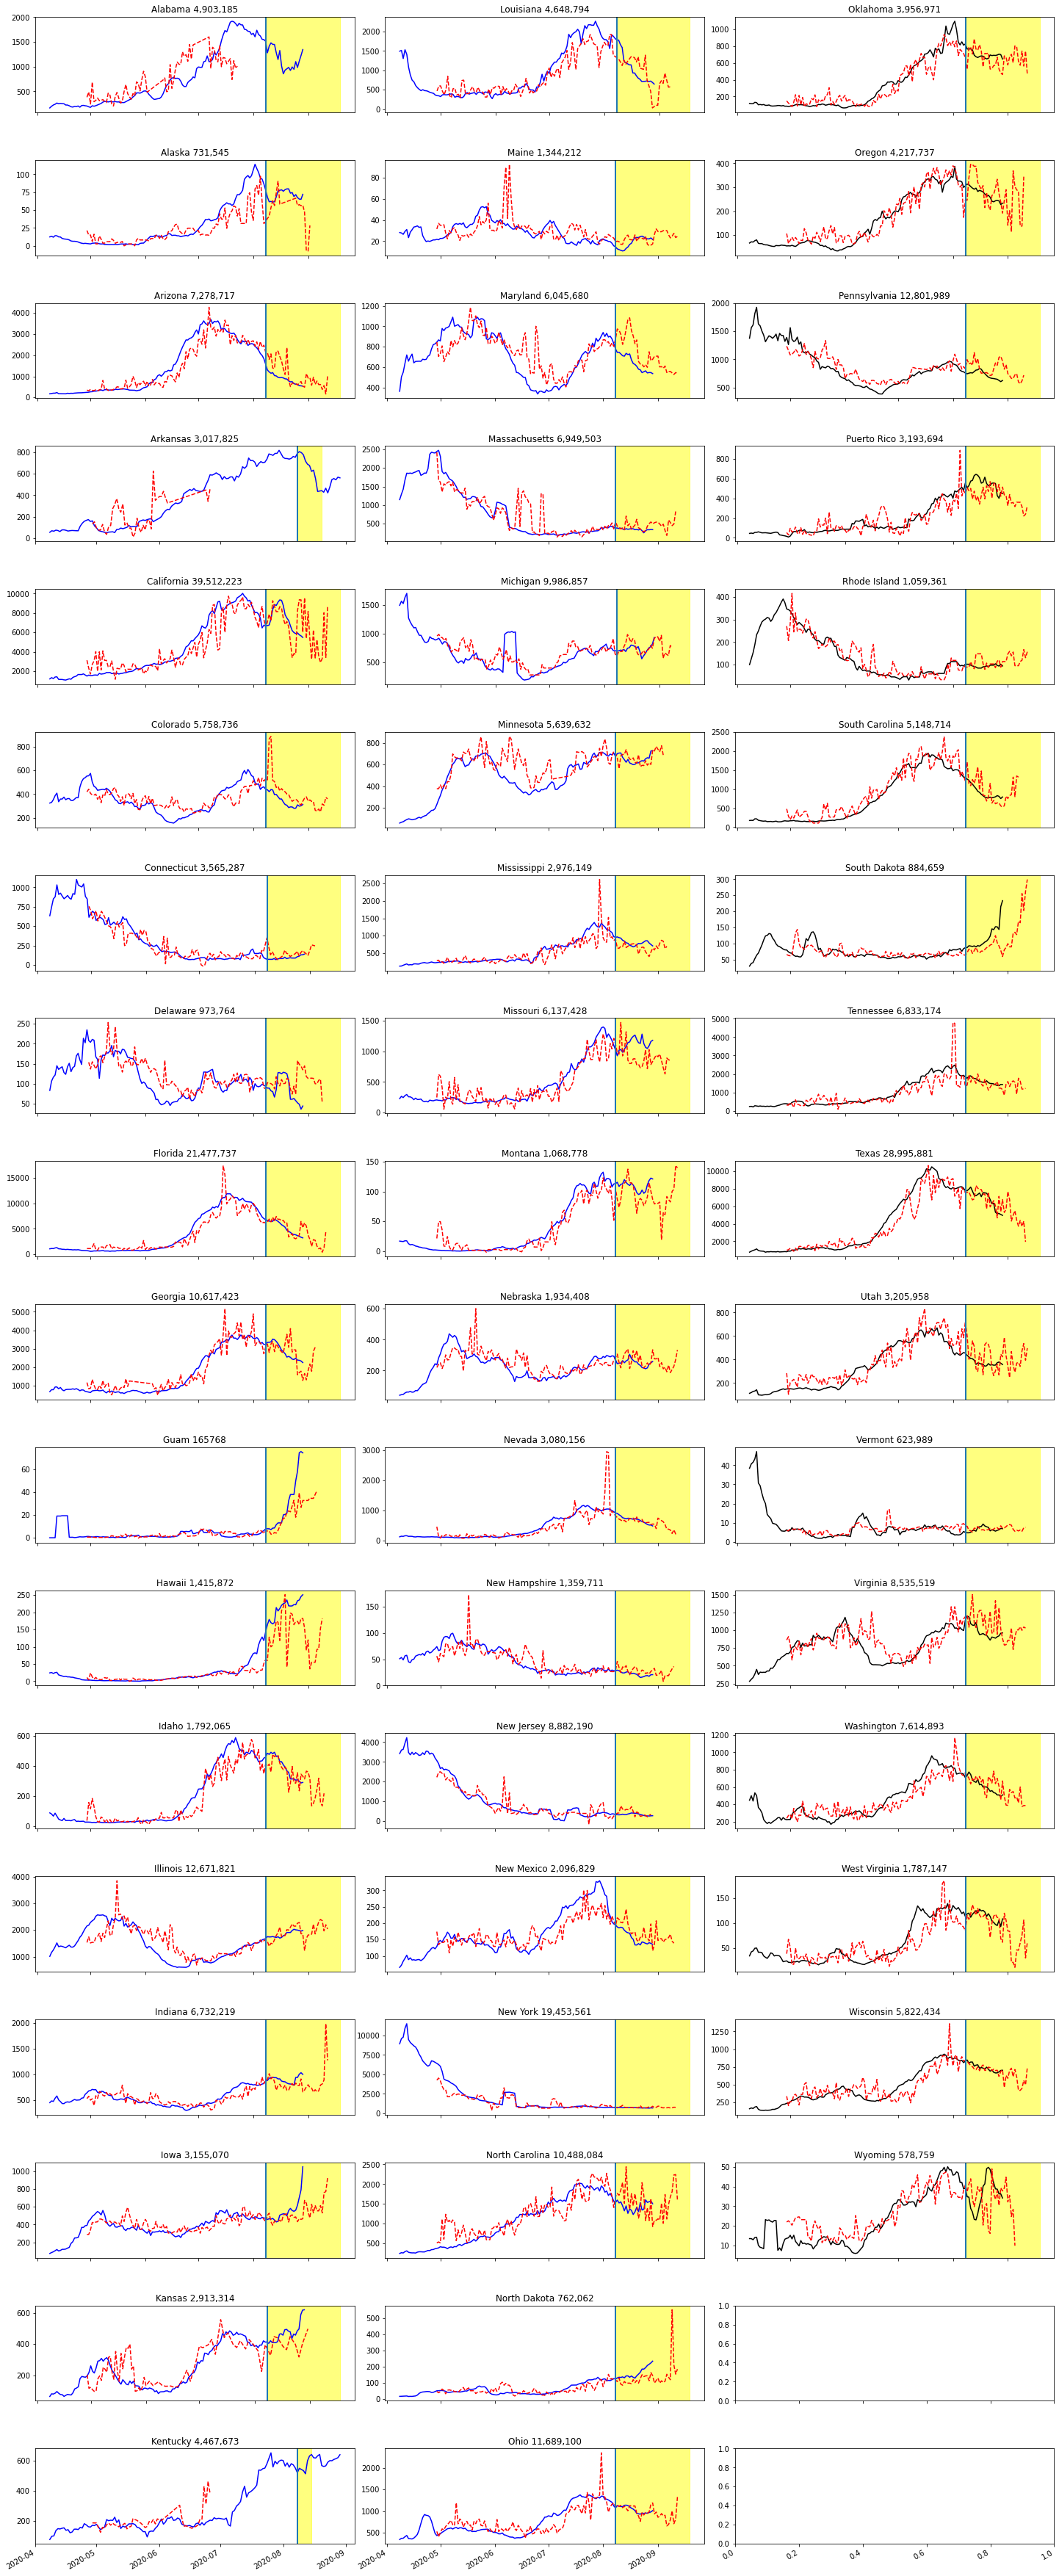

In [113]:
states = prediction_allstates['state'].unique()
states = sorted(states)

fig, axs = plt.subplots(18,3,figsize=(20,60))
fig.tight_layout()
plt.subplots_adjust(hspace = 0.5)

fig.autofmt_xdate()
vline = wkslater.iloc[-1]['date'] - timedelta(weeks=3)


states_s = states[0:18]
rows = range(0,len(states_s))
for row in rows:
    try:
        state = states_s[row]
        x = covid_unscaled[(covid_unscaled.state == state)]['later_date']
        y = covid_unscaled[(covid_unscaled.state == state)]['prediction']
        x2 = covidperav[(covidperav.state == state)]['date']
        y2 = covidperav[(covidperav.state == state)]['cases']
        population = populations[(populations.state ==state)].iloc[0].population
        population = str(population)
        axs[row,0].plot(x2,y2,'k')
        axs[row,0].plot(x,y,'--',c='r')
        axs[row,0].set_title(state +' '+ population)
        axs[row,0].axvline(vline, linewidth=2) 
        axs[row,0].axvspan(vline, max(x), alpha=0.5, color='yellow')

    except KeyError:
        pass

states_s = states[18:36]
rows = range(0,len(states_s))
for row in rows:
    try:
        state = states_s[row]
        x = covid_unscaled[(covid_unscaled.state == state)]['later_date']
        y = covid_unscaled[(covid_unscaled.state == state)]['prediction']
        x2 = covidperav[(covidperav.state == state)]['date']
        y2 = covidperav[(covidperav.state == state)]['cases']
        population = populations[(populations.state ==state)].iloc[0].population
        population = str(population)
        axs[row,1].plot(x2,y2,'k')
        axs[row,1].plot(x,y,'--',c='r')
        axs[row,1].set_title(state +' '+ population)
        axs[row,1].axvline(vline, linewidth=2)
        axs[row,1].axvspan(vline, max(x), alpha=0.5, color='yellow')

    except KeyError:
        pass
    
states_s = states[36:54]
rows = range(0,len(states_s))
for row in rows:
    try:
        state = states_s[row]
        x = covid_unscaled[(covid_unscaled.state == state)]['later_date']
        y = covid_unscaled[(covid_unscaled.state == state)]['prediction']
        x2 = covidperav[(covidperav.state == state)]['date']
        y2 = covidperav[(covidperav.state == state)]['cases']
        population = populations[(populations.state ==state)].iloc[0].population
        population = str(population)        
        axs[row,2].plot(x2,y2,'k')
        axs[row,2].plot(x,y,'--',c='r')
        axs[row,2].set_title(state +' '+ population)
        axs[row,2].axvline(vline, linewidth=2)
        axs[row,2].axvspan(vline, max(x), alpha=0.5, color='yellow')
    except KeyError:
        pass
    
plt.savefig('3wks_beforepeak.png')
plt.show()

In [114]:
# Remove commas and convert to float 
populations = populations.replace(',','',regex=True)
populations['population'] = populations['population'].astype(float)

In [115]:
wkslater.iloc[-1]['date']- timedelta(weeks=3)

Timestamp('2020-08-08 00:00:00')

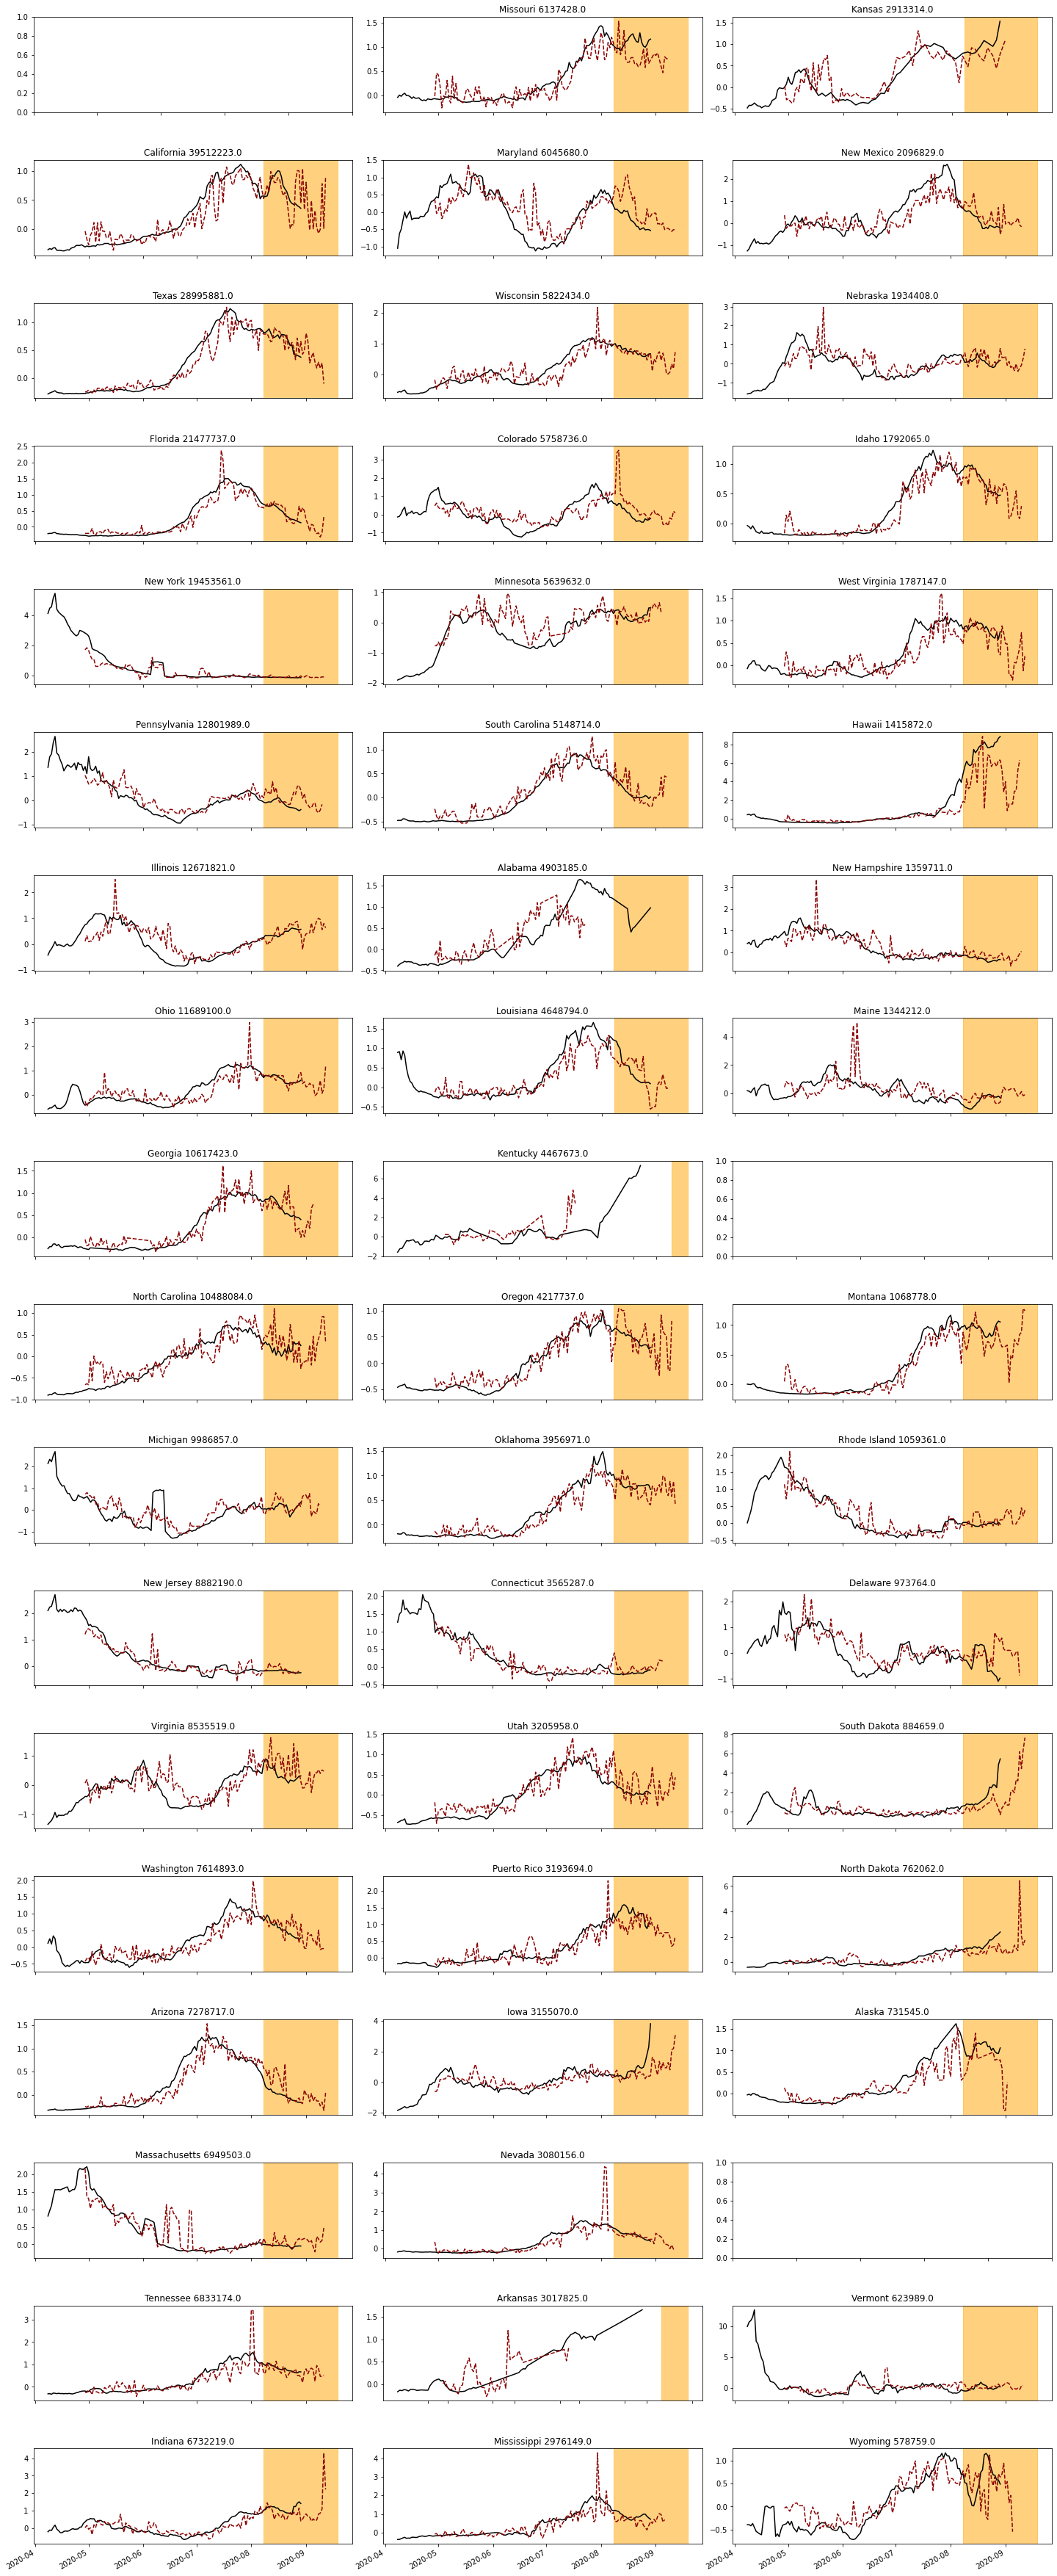

In [117]:
populations = populations.sort_values(by=['population'], ascending=False)
states = populations['state'].unique()

fig, axs = plt.subplots(18,3,figsize=(20,60))
fig.tight_layout()
plt.subplots_adjust(hspace = 0.5)

fig.autofmt_xdate()
vline = wkslater.iloc[-1]['date'] - timedelta(weeks=3)


states_s = states[0:18]
rows = range(0,len(states_s))
for row in rows:
    state = states_s[row]
    if len(prediction_allstates[(prediction_allstates.state == state)])>1:
        try:
            x = prediction_allstates[(prediction_allstates.state == state)]['later_date']
            y = prediction_allstates[(prediction_allstates.state == state)]['prediction']
            x2 = prediction_allstates[(prediction_allstates.state == state)]['date']
            y2 = prediction_allstates[(prediction_allstates.state == state)]['cases']
            population = populations[(populations.state ==state)].iloc[0].population
            population = str(population)
            axs[row,0].plot(x2,y2,'k')
            axs[row,0].plot(x,y,'--',c='darkred')
            axs[row,0].set_title(state +' '+ population)
            axs[row,0].axvspan(vline, max(x), alpha=0.5, color='orange')

        except KeyError:
            pass
    else:
        pass

states_s = states[18:36]
rows = range(0,len(states_s))
for row in rows:
    state = states_s[row]
    if len(prediction_allstates[(prediction_allstates.state == state)])>1:
        try:
            
            x = prediction_allstates[(prediction_allstates.state == state)]['later_date']
            y = prediction_allstates[(prediction_allstates.state == state)]['prediction']
            x2 = prediction_allstates[(prediction_allstates.state == state)]['date']
            y2 = prediction_allstates[(prediction_allstates.state == state)]['cases']
            population = populations[(populations.state ==state)].iloc[0].population
            population = str(population)
            axs[row,1].plot(x2,y2,'k')
            axs[row,1].plot(x,y,'--',c='darkred')
            axs[row,1].set_title(state +' '+ population)
            axs[row,1].axvspan(vline, max(x), alpha=0.5, color='orange')

        except KeyError:
            pass
    
    
states_s = states[36:54]
rows = range(0,len(states_s))
for row in rows:
    state = states_s[row]
    if len(prediction_allstates[(prediction_allstates.state == state)])>1:
        try:
            
            x = prediction_allstates[(prediction_allstates.state == state)]['later_date']
            y = prediction_allstates[(prediction_allstates.state == state)]['prediction']
            x2 = prediction_allstates[(prediction_allstates.state == state)]['date']
            y2 = prediction_allstates[(prediction_allstates.state == state)]['cases']
            population = populations[(populations.state ==state)].iloc[0].population
            population = str(population)
            axs[row,2].plot(x2,y2,'k')
            axs[row,2].plot(x,y,'--',c='darkred')
            axs[row,2].set_title(state +' '+ population)
            axs[row,2].axvspan(vline, max(x), alpha=0.5, color='orange')

        except KeyError:
            pass
    
    
plt.savefig('KNN3wks_beforepeak.png')
plt.show()

In [57]:
# Sort by date and take the first 80% to train
covid_scaled_test = wkslater.sort_values(by = ['date'])[0:round(len(covid_scaled)*0.80)].reset_index(drop =True)
covid_scaled_test = covid_scaled_test.dropna(axis='rows')
st_wkslinear = covid_scaled_test[['cases','later_case','slope','deaths','death_slope','positive','total','percent','percentav']]



# TRAIN MODEL MULTIPLE TIMES FOR BEST SCORE
best = 0
for _ in range(30):
    train , test = train_test_split(st_wkslinear, test_size = 0.1)
    x_train = train.drop('later_case', axis=1)
    y_train = train['later_case']
    x_test = test.drop('later_case', axis=1)
    y_test = test['later_case']

    linear = linear_model.LinearRegression()

    linear.fit(x_train, y_train)
    acc = linear.score(x_test, y_test)
    print("Accuracy: " + str(acc))
    
    # If the current model has a better score than one we've already trained then save it
    if acc > best:
        best = acc
        with open("cases.pickle", "wb") as f:
            pickle.dump(linear, f)


Accuracy: 0.4167538145902979
Accuracy: 0.4208403279307058
Accuracy: 0.3675923224500721
Accuracy: 0.354219443967174
Accuracy: 0.2670873257591404
Accuracy: 0.36642893108005414
Accuracy: 0.4034518068836428
Accuracy: 0.38596364806508465
Accuracy: 0.38062182100513153
Accuracy: 0.4334629760374987
Accuracy: 0.4206963842329483
Accuracy: 0.40917415141333424
Accuracy: 0.40212176512851816
Accuracy: 0.42323457866168235
Accuracy: 0.3690899758134121
Accuracy: 0.46702897692171963
Accuracy: 0.3226398745816863
Accuracy: 0.3830889527178828
Accuracy: 0.400086980363064
Accuracy: 0.35074686825834167
Accuracy: 0.3865643352634208
Accuracy: 0.3885369209374022
Accuracy: 0.4108358648022399
Accuracy: 0.4249575136501743
Accuracy: 0.4115845551534575
Accuracy: 0.43814953839182724
Accuracy: 0.41964339081937463
Accuracy: 0.4009428176790151
Accuracy: 0.35981806506037917
Accuracy: 0.424723499877273


In [58]:
state = 'Florida'
# 3>2
fl_wks = wkslater[(wkslater.state == state)].reset_index(drop=True)
fl_wks_resultdate = fl_wks[['date']]


fl_wks_param = fl_wks[['cases','later_case','slope','deaths','death_slope','positive','total','percent','percentav']]
fl_wks_param = fl_wks_param.dropna(axis='rows')

fl_wks_result = fl_wks[['later_case']]
x_test = fl_wks_param.drop(['later_case'],axis='columns')


pickle_in = open("cases.pickle", "rb")
linear = pickle.load(pickle_in)


predictions = linear.predict(x_test) # Gets a list of all predictions


diff = len(fl_wks_result)-len(predictions)
addnon = [[]]*diff
addnon[0].append(np.nan)

predictions =np.append(predictions,addnon)
predictions = pd.DataFrame(predictions, columns=['prediction'])
predictions = predictions.reset_index(drop=True)
fl_wks_result = pd.concat([fl_wks,predictions], axis=1)

In [59]:
state = 'Vermont'
# 3>2
st_wks = wkslater[(wkslater.state == state)].reset_index(drop=True)
st_wks_resultdate = st_wks[['date']]


st_wks_param = st_wks[['cases','later_case','slope','deaths','death_slope','positive','total','percent','percentav']]
st_wks_param = st_wks_param.dropna(axis='rows')

st_wks_result = st_wks[['later_case']]
x_test = st_wks_param.drop(['later_case'],axis='columns')

pickle_in = open("cases.pickle", "rb")
linear = pickle.load(pickle_in)


predictions = linear.predict(x_test) # Gets a list of all predictions


diff = len(st_wks_result)-len(predictions)
addnon = [[]]*diff
addnon[0].append(np.nan)

predictions =np.append(predictions,addnon)
predictions = pd.DataFrame(predictions, columns=['prediction'])
predictions = predictions.reset_index(drop=True)
st_wks_result = pd.concat([st_wks,predictions], axis=1)

In [60]:
st_wks_result = st_wks_result.sort_values(by=['date'])
st_wks_result = st_wks_result.reset_index(drop=True)
fl_wks_result = fl_wks_result.sort_values(by=['date'])
fl_wks_result = fl_wks_result.reset_index(drop=True)
fl_wks_result['later_date'] = pd.to_datetime(fl_wks_result['later_date'], format = '%Y-%m-%d')
st_wks_result['later_date'] = pd.to_datetime(st_wks_result['later_date'], format = '%Y-%m-%d')

Text(0.5, 1.0, 'Vermont')

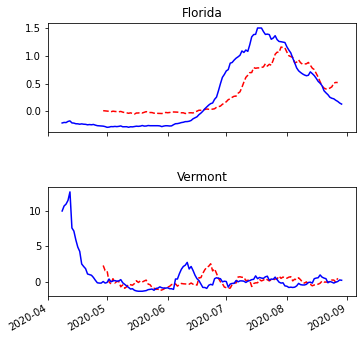

In [61]:
fig, axs = plt.subplots(2,figsize=(5,5))

fig.tight_layout()
plt.subplots_adjust(hspace = 0.5)

fig.autofmt_xdate()

# prediction
x = fl_wks_result['later_date']
y = fl_wks_result['prediction']
# actual
x2 = fl_wks_result['date']
y2 = fl_wks_result['cases']
axs[0].plot(x,y,linestyle = '--',c='r')
axs[0].plot(x2,y2,'b')
axs[0].set_title('Florida')


# prediction
x = st_wks_result['later_date']
y = st_wks_result['prediction']
# actual
x2 = st_wks_result['date']
y2 = st_wks_result['cases']
axs[1].plot(x,y,linestyle = '--',c='r')
axs[1].plot(x2,y2,'b')
axs[1].set_title(state)

In [62]:
covid_scaled_test = wkslater.sort_values(by = ['date'])[0:round(len(covid_scaled)*0.80)].reset_index(drop =True)
covid_scaled_test = covid_scaled_test.dropna(axis='rows')
st_wkslinear = covid_scaled_test[['later_case','cases','slope','deaths','death_slope','positive','total','percent','percentav']]
var = st_wkslinear.columns.tolist()[1:8]

In [63]:
import random
random.sample(var, 2)

['death_slope', 'deaths']

In [64]:
covid_scaled_test = wkslater.sort_values(by = ['date'])[0:round(len(covid_scaled)*0.80)].reset_index(drop =True)
covid_scaled_test = covid_scaled_test.dropna(axis='rows')
st_wkslinear = covid_scaled_test[['later_case','cases','slope','deaths','death_slope','positive','total','percent','percentav']]



for _ in range(50):
    var = st_wkslinear.columns.tolist()[1:8]
    columns = random.sample(var, 2)
    best = 0
    for _ in range(30):
        train , test = train_test_split(st_wkslinear, test_size = 0.2)
        x_train = train[columns]
        y_train = train['later_case']
        x_test = test[columns]
        y_test = test['later_case']
        linear = linear_model.LinearRegression()
        linear.fit(x_train, y_train)
        acc = linear.score(x_test, y_test)
        if acc > best:
            best = acc
    print(str(columns) + ' ' + str(best))

['slope', 'total'] 0.12365348523239406
['slope', 'total'] 0.11571224426128457
['percent', 'positive'] 0.04822334475255974
['total', 'deaths'] 0.04213388145898722
['positive', 'deaths'] 0.037220740648208794
['slope', 'death_slope'] 0.11780197493961608
['deaths', 'total'] 0.04424249053021734
['total', 'deaths'] 0.04884930073298421
['death_slope', 'percent'] 0.04290601368164304
['slope', 'deaths'] 0.09690524254410615
['cases', 'deaths'] 0.16913682977417244
['total', 'percent'] 0.05302470010926519
['slope', 'positive'] 0.12154147835317208
['positive', 'death_slope'] 0.04350738241146124
['total', 'cases'] 0.17181908169957294
['percent', 'positive'] 0.04649246378727134
['percent', 'cases'] 0.19165115956511303
['cases', 'death_slope'] 0.16844155758573487
['percent', 'death_slope'] 0.04673481984411598
['cases', 'death_slope'] 0.1636354922101767
['positive', 'deaths'] 0.05034417737149299
['cases', 'total'] 0.17740527938963357
['total', 'deaths'] 0.052868735412154866
['death_slope', 'slope'] 0.1

In [65]:
covid_scaled_test = wkslater.sort_values(by = ['date'])[0:round(len(covid_scaled)*0.80)].reset_index(drop =True)
covid_scaled_test = covid_scaled_test.dropna(axis='rows')
st_wkslinear = covid_scaled_test[['later_case','cases','slope','deaths','death_slope','positive','total','percent','percentav']]



for _ in range(50):
    var = st_wkslinear.columns.tolist()[1:8]
    columns = random.sample(var, 3)
    best = 0
    for _ in range(30):
        train , test = train_test_split(st_wkslinear, test_size = 0.2)
        x_train = train[columns]
        y_train = train['later_case']
        x_test = test[columns]
        y_test = test['later_case']
        linear = linear_model.LinearRegression()
        linear.fit(x_train, y_train)
        acc = linear.score(x_test, y_test)
        if acc > best:
            best = acc
    print(str(columns) + ' ' + str(best))

['slope', 'total', 'percent'] 0.11916023009098786
['slope', 'death_slope', 'positive'] 0.11828610133776607
['death_slope', 'percent', 'slope'] 0.1296493942123239
['slope', 'death_slope', 'deaths'] 0.13044463396122874
['slope', 'cases', 'positive'] 0.42800157324762134
['percent', 'positive', 'deaths'] 0.047856857894161275
['positive', 'slope', 'deaths'] 0.11902558744019542
['percent', 'cases', 'deaths'] 0.1681600734278086
['positive', 'deaths', 'percent'] 0.048621142766150816
['slope', 'percent', 'death_slope'] 0.1107463428868879
['death_slope', 'deaths', 'percent'] 0.04374893012168535
['deaths', 'total', 'positive'] 0.045740463113845276
['death_slope', 'deaths', 'slope'] 0.12068319910777092
['deaths', 'positive', 'slope'] 0.1284422853754903
['slope', 'death_slope', 'total'] 0.12071692322523242
['percent', 'deaths', 'cases'] 0.1992404498756295
['cases', 'total', 'deaths'] 0.20789659771694957
['slope', 'total', 'percent'] 0.11786905940119985
['positive', 'slope', 'deaths'] 0.116034340572

In [66]:
# Sort by date and take the first 80% to train
covid_scaled_test = wkslater.sort_values(by = ['date'])[0:round(len(covid_scaled)*0.80)].reset_index(drop =True)
covid_scaled_test = covid_scaled_test.dropna(axis='rows')
st_wkslinear = covid_scaled_test[['cases','later_case','slope','deaths','death_slope']]



# TRAIN MODEL MULTIPLE TIMES FOR BEST SCORE
best = 0
for _ in range(30):
    train , test = train_test_split(st_wkslinear, test_size = 0.1)
    x_train = train.drop('later_case', axis=1)
    y_train = train['later_case']
    x_test = test.drop('later_case', axis=1)
    y_test = test['later_case']

    linear = linear_model.LinearRegression()

    linear.fit(x_train, y_train)
    acc = linear.score(x_test, y_test)
    print("Accuracy: " + str(acc))
    
    # If the current model has a better score than one we've already trained then save it
    if acc > best:
        best = acc
        with open("cases.pickle", "wb") as f:
            pickle.dump(linear, f)



Accuracy: 0.19651497501982673
Accuracy: 0.21496221341899613
Accuracy: 0.3697688083430808
Accuracy: 0.3422857108945979
Accuracy: 0.34504472356770965
Accuracy: 0.33459642500462283
Accuracy: 0.28657922368719524
Accuracy: 0.33627406605168064
Accuracy: 0.25334436385385184
Accuracy: 0.308329513961057
Accuracy: 0.36238481965014935
Accuracy: 0.2003874718738543
Accuracy: 0.39888246843217756
Accuracy: 0.41788017820064105
Accuracy: 0.3651975208867936
Accuracy: 0.4114254239701435
Accuracy: 0.4562850559842474
Accuracy: 0.36063693106128825
Accuracy: 0.4195743318055579
Accuracy: 0.38628054336781026
Accuracy: 0.31374637872843014
Accuracy: 0.27812357009974176
Accuracy: 0.4433918111790879
Accuracy: 0.322598819461717
Accuracy: 0.391175237108357
Accuracy: 0.3104415095483699
Accuracy: 0.3653353601452216
Accuracy: 0.1948288567592209
Accuracy: 0.3580719106698945
Accuracy: 0.4555543756376156


In [67]:
state = 'Florida'

fl_wks = wkslater[(wkslater.state == state)].reset_index(drop=True)
fl_wks_resultdate = fl_wks[['date']]


fl_wks_param = fl_wks[['cases','later_case','slope','deaths','death_slope']]
fl_wks_param = fl_wks_param.dropna(axis='rows')

fl_wks_result = fl_wks[['later_case']]
x_test = fl_wks_param.drop(['later_case'],axis='columns')


pickle_in = open("cases.pickle", "rb")
linear = pickle.load(pickle_in)


predictions = linear.predict(x_test) # Gets a list of all predictions


diff = len(fl_wks_result)-len(predictions)
addnon = [[]]*diff
addnon[0].append(np.nan)

predictions =np.append(predictions,addnon)
predictions = pd.DataFrame(predictions, columns=['prediction'])
predictions = predictions.reset_index(drop=True)
fl_wks_result = pd.concat([fl_wks,predictions], axis=1)

In [68]:
state = 'Vermont'
# 3>2
st_wks = wkslater[(wkslater.state == state)].reset_index(drop=True)
st_wks_resultdate = st_wks[['date']]


st_wks_param = st_wks[['cases','later_case','slope','deaths','death_slope']]
st_wks_param = st_wks_param.dropna(axis='rows')

st_wks_result = st_wks[['later_case']]
x_test = st_wks_param.drop(['later_case'],axis='columns')

pickle_in = open("cases.pickle", "rb")
linear = pickle.load(pickle_in)


predictions = linear.predict(x_test) # Gets a list of all predictions


diff = len(st_wks_result)-len(predictions)
addnon = [[]]*diff
addnon[0].append(np.nan)

predictions =np.append(predictions,addnon)
predictions = pd.DataFrame(predictions, columns=['prediction'])
predictions = predictions.reset_index(drop=True)
st_wks_result = pd.concat([st_wks,predictions], axis=1)

Text(0.5, 1.0, 'Vermont')

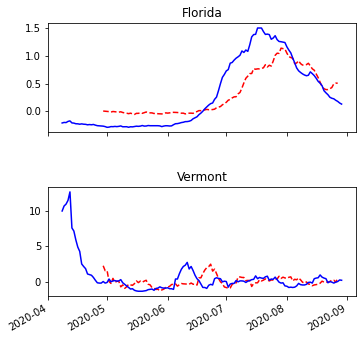

In [69]:
fig, axs = plt.subplots(2,figsize=(5,5))

fig.tight_layout()
plt.subplots_adjust(hspace = 0.5)

fig.autofmt_xdate()

# prediction
x = fl_wks_result['later_date']
y = fl_wks_result['prediction']
# actual
x2 = fl_wks_result['date']
y2 = fl_wks_result['cases']
axs[0].plot(x,y,linestyle = '--',c='r')
axs[0].plot(x2,y2,'b')
axs[0].set_title('Florida')


# prediction
x = st_wks_result['later_date']
y = st_wks_result['prediction']
# actual
x2 = st_wks_result['date']
y2 = st_wks_result['cases']
axs[1].plot(x,y,linestyle = '--',c='r')
axs[1].plot(x2,y2,'b')
axs[1].set_title(state)

In [70]:
# Sort by date and take the first 80% to train
covid_scaled_test = wkslater.sort_values(by = ['date'])[0:round(len(covid_scaled)*0.80)].reset_index(drop =True)
covid_scaled_test = covid_scaled_test.dropna(axis='rows')
st_wkslinear = covid_scaled_test[['later_case','cases','slope','deaths','death_slope','positive','total','percent','percentav']]


train , test = train_test_split(st_wkslinear, test_size = 0.1)
x_train = train.drop('later_case', axis=1)
y_train = train['later_case']
x_test = test.drop('later_case', axis=1)
y_test = test['later_case']



In [71]:
acc

0.4555543756376156

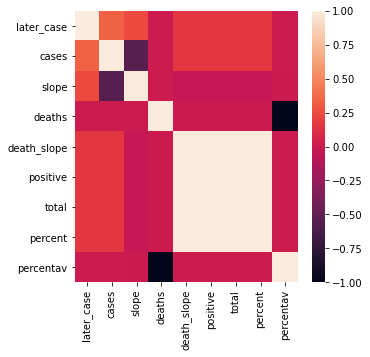

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(1,figsize=(5,5))
corr = st_wkslinear.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()